# Word Embeddings

*Adapted from tutorial: https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial#Training-the-model*

In [1]:
import pandas as pd
import numpy as np
from time import time
from collections import defaultdict
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from topic_modeling import prep_text

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

Load in data

In [3]:
# Load preprocessed text (nouns only)
import pickle

infile = open('processed_text.pkl','rb')
text_l = pickle.load(infile)
infile.close()

In [ ]:
# Define min_df and max_df
min_df = 35
max_df = 5310

In [ ]:
text = prep_text(text_l)

Word2Vec model

In [9]:
# Instantiate model
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=4)

In [10]:
# Build vocabulary
t = time()

w2v_model.build_vocab(text, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:24:48: collecting all words and their counts
INFO - 13:24:48: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:24:48: PROGRESS: at sentence #10000, processed 324227 words, keeping 22648 word types
INFO - 13:24:48: PROGRESS: at sentence #20000, processed 632580 words, keeping 33013 word types
INFO - 13:24:48: PROGRESS: at sentence #30000, processed 936693 words, keeping 40821 word types
INFO - 13:24:48: PROGRESS: at sentence #40000, processed 1214746 words, keeping 46594 word types
INFO - 13:24:48: collected 48741 word types from a corpus of 1302715 raw words and 43262 sentences
INFO - 13:24:48: Loading a fresh vocabulary
INFO - 13:24:48: effective_min_count=20 retains 4670 unique words (9% of original 48741, drops 44071)
INFO - 13:24:48: effective_min_count=20 leaves 1177828 word corpus (90% of original 1302715, drops 124887)
INFO - 13:24:48: deleting the raw counts dictionary of 48741 items
INFO - 13:24:48: sample=6e-05 downsamples 1140 most-common

Time to build vocab: 0.04 mins


In [11]:
# Train model
t = time()

w2v_model.train(text, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:24:58: training model with 4 workers on 4670 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 13:24:59: EPOCH 1 - PROGRESS: at 29.25% examples, 165848 words/s, in_qsize 7, out_qsize 0
INFO - 13:25:00: EPOCH 1 - PROGRESS: at 67.91% examples, 185623 words/s, in_qsize 8, out_qsize 1
INFO - 13:25:01: worker thread finished; awaiting finish of 3 more threads
INFO - 13:25:01: worker thread finished; awaiting finish of 2 more threads
INFO - 13:25:01: worker thread finished; awaiting finish of 1 more threads
INFO - 13:25:01: worker thread finished; awaiting finish of 0 more threads
INFO - 13:25:01: EPOCH - 1 : training on 1302715 raw words (539709 effective words) took 2.7s, 196716 effective words/s
INFO - 13:25:02: EPOCH 2 - PROGRESS: at 33.70% examples, 193208 words/s, in_qsize 7, out_qsize 0
INFO - 13:25:03: EPOCH 2 - PROGRESS: at 73.51% examples, 202896 words/s, in_qsize 6, out_qsize 1
INFO - 13:25:04: worker thread finished; awaiting finish o

Time to train the model: 1.6 mins


In [12]:
# Making model more memory-efficient
w2v_model.init_sims(replace=True)

INFO - 13:28:10: precomputing L2-norms of word weight vectors


Model testing/exploration

In [38]:
# Most similar
w2v_model.wv.most_similar(positive=['pneumonia'])

[('halo_sign', 0.6309974193572998),
 ('pneumoniae', 0.6099082827568054),
 ('patchy_ground_glass', 0.607473611831665),
 ('ground_glass_opacity', 0.6068877577781677),
 ('ground_glass_opacities', 0.6047185063362122),
 ('computer_tomography', 0.5904011130332947),
 ('spontaneous_pneumothorax', 0.5872418880462646),
 ('computed_tomography', 0.5851549506187439),
 ('thin_section', 0.5804590582847595),
 ('patchy', 0.5761443376541138)]

In [39]:
# Similarity
w2v_model.wv.similarity('pneumonia', 'lung')

0.5334703

In [34]:
# Does not belong
w2v_model.wv.doesnt_match(['lung', 'kidney', 'distancing'])

'distancing'

In [35]:
# Analogy difference
w2v_model.wv.most_similar(positive=['vaccine', 'lung'], negative=['pneumonia'], topn=3)

[('immunogenicity', 0.5116674900054932),
 ('candidate', 0.4473339021205902),
 ('therapeutic', 0.441127747297287)]

Visualization

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

def tsnescatterplot(model, word, list_names):
    """
    Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 15 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

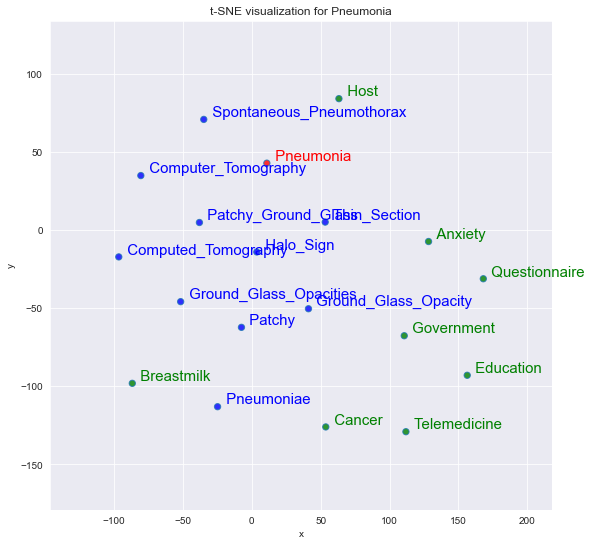

In [51]:
# Most similar vs. random
tsnescatterplot(w2v_model, 'pneumonia', ['breastmilk', 'government', 'cancer', 'education', 'anxiety', 'questionnaire',
                                         'host', 'telemedicine'])

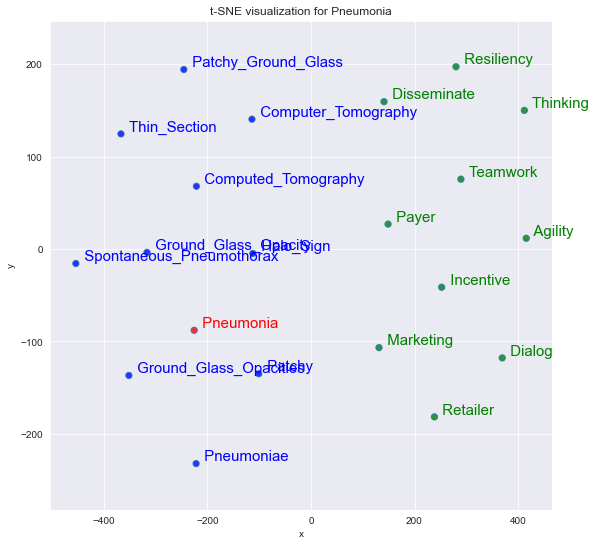

In [55]:
# Most similar vs. most dissimilar
tsnescatterplot(w2v_model, 'pneumonia', [i[0] for i in w2v_model.wv.most_similar(negative=['pneumonia'])])

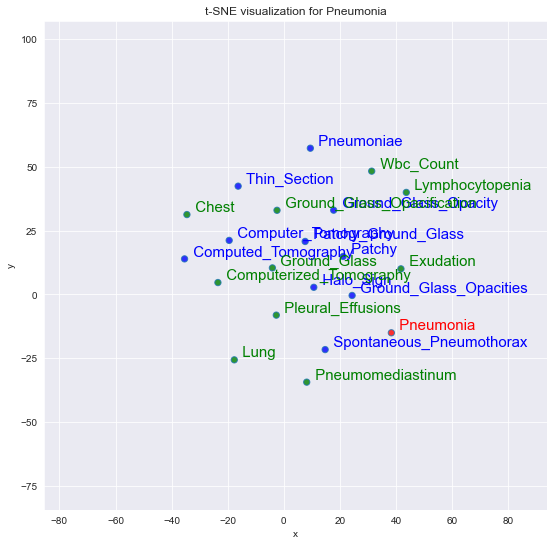

In [56]:
# Top 10 vs. top 11-20
tsnescatterplot(w2v_model, 'pneumonia', [t[0] for t in w2v_model.wv.most_similar(positive=['pneumonia'], topn=20)][10:])